In [ ]:
#import Dependencies
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpus =  tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
print('men: ',len(os.listdir('drive/MyDrive/Training/Datasets/men_women_classification/men')), ' samples')
print('women: ', len(os.listdir('drive/MyDrive/Training/Datasets/men_women_classification/women')),' samples')

men:  367  samples
women:  270  samples


# Cleaning


In [ ]:
data_dir = 'drive/MyDrive/Training/Datasets/men_women_classification'
image_exts = ['jpeg', 'jpg', 'png', 'bmp']
image_calss = os.listdir(data_dir)

In [ ]:
def Remove_outliers(data_dir = data_dir):
  for image_class in os.listdir(data_dir):
      class_dir = os.path.join(data_dir, image_class)
      if os.path.isdir(class_dir):
          for image in os.listdir(class_dir):
              image_path = os.path.join(class_dir, image)
              try:
                  img = cv2.imread(image_path)
                  img_extension = imghdr.what(image_path)
                  if img_extension not in image_exts:
                      print('Image not in ext list: {}'.format(image_path))
                      os.remove(image_path)
              except Exception as e:
                  print('Issue with image {}: {}'.format(image_path, str(e)))

In [ ]:
Remove_outliers()

# Load Data

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256), batch_size=32)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 637 files belonging to 2 classes.


# Visualusation

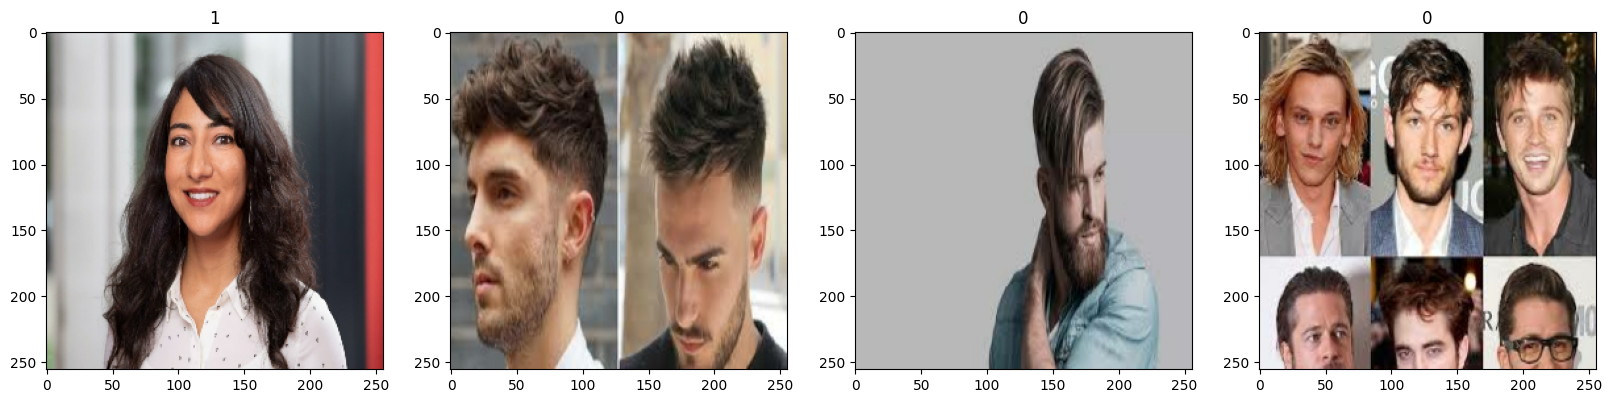

In [ ]:
fig, ax = plt.subplots(ncols=4 , figsize=(20,20))
for idx, img in enumerate(batch[0][0:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 0 ==> men
# 1 ==> women

# Preprocessing

In [ ]:
#Scale Data
data = data.map(lambda x,y: (x/255, y))

# Splitting data

In [ ]:
train_size = int(len(data) * 0.7)
val_size   = int(len(data) * 0.2) + 1
test_size  = int(len(data) * 0.1) + 1

In [ ]:
train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size).take(test_size)

# The model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
#Create the model
model = Sequential()

In [ ]:
#(1, 256, 256, 3)
model.add(Conv2D(16, (3,3), 1 , activation='relu', input_shape = (256, 256, 3)))    #TensorShape([1, 254, 254, 16])
model.add(MaxPooling2D())                                                           #TensorShape([1, 127, 127, 16])

In [ ]:
model.add(Conv2D(32, (3,3), 1 , activation= 'relu'))                                #TensorShape([1, 125, 125, 32])
model.add(MaxPooling2D())                                                           #TensorShape([1, 62, 62, 32])

In [ ]:
model.add(Conv2D(16, (3,3), 1 , activation= 'relu'))                                #TensorShape([1, 60, 60, 16])
model.add(MaxPooling2D())                                                           #TensorShape([1, 30, 30, 16])

In [ ]:
model.add(Flatten())                                                                #TensorShape([1, 14400])

In [ ]:
model.add(Dense(256, activation='relu'))                                            #TensorShape([1, 256])
model.add(Dense(1, activation='sigmoid'))                                            #TensorShape([1, 1])

In [ ]:
# compile the model
model.compile(
    optimizer='adam',
    loss= tf.losses.BinaryCrossentropy(),
    metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [ ]:
#Fit the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir ='logs')

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
14/14 [==============================] - 24s 608ms/step - loss: 0.7339 - accuracy: 0.4888 - val_loss: 0.6907 - val_accuracy: 0.4437
Epoch 2/20
14/14 [==============================] - 11s 646ms/step - loss: 0.6766 - accuracy: 0.6071 - val_loss: 0.6285 - val_accuracy: 0.6187
Epoch 3/20
14/14 [==============================] - 11s 562ms/step - loss: 0.6070 - accuracy: 0.7076 - val_loss: 0.5757 - val_accuracy: 0.7188
Epoch 4/20
14/14 [==============================] - 11s 674ms/step - loss: 0.5159 - accuracy: 0.7746 - val_loss: 0.4586 - val_accuracy: 0.8188
Epoch 5/20
14/14 [==============================] - 11s 656ms/step - loss: 0.4384 - accuracy: 0.8125 - val_loss: 0.3728 - val_accuracy: 0.8562
Epoch 6/20
14/14 [==============================] - 12s 683ms/step - loss: 0.3895 - accuracy: 0.8348 - val_loss: 0.4086 - val_accuracy: 0.7688
Epoch 7/20
14/14 [==============================] - 11s 634ms/step - loss: 0.2996 - accuracy: 0.8996 - val_loss: 0.2146 - val_accuracy: 0.9250

In [ ]:
print(f'Validation accuracy: {tf.round(model.evaluate(val, verbose=0)[1]*100,2)}%')
print(f'Test accuracy: {tf.round(model.evaluate(test, verbose=0)[1]*100,2)}%')

Validation accuracy: 100.0%
Test accuracy: 100.0%


# Save Model


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('drive/MyDrive/Training/Save_models', 'MWC_model.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#import the model
#new_model = load_model(os.path.join('drive/MyDrive/models', 'HSIClassification.h5'))